# Creating a simple multi-stock backtest using Pandas

The goal of this document is to test two multi-stock strategies, based on momentum strategies, on 10 Danish stocks. 
While backtesting.py is a wonderful tool, that creates lovely results, it is not designed with multi-stock algorithms in mind.
Therefore, this document will not use backtesting.py, instead it will rely on Pandas.

In [30]:
# Load libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs

In [31]:
# Load data
instruments = ["NOVO-B.CO","DANSKE.CO","VWS.CO","NSIS-B.CO","ORSTED.CO","PNDORA.CO","TRYG.CO","COLO-B.CO","DSV.CO","CARL-B.CO"]

# Define the portfolio (dataframe only containing close columns)
portfolio = pd.DataFrame()

for symbol in instruments:
    # Download data with yf
    df = yf.download(symbol, start="2016-08-01", auto_adjust=True) # The start date is due to Ørsted A/S having no data before the date
    # Populate the portfolio
    portfolio[symbol] = df["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [32]:
# Define the log returns
log_r = np.log(portfolio / portfolio.shift(1))
# Define monthly returns
ret_m = log_r.resample('M').sum()

C:\Users\hedeh\AppData\Local\Temp\ipykernel_34060\2486664552.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ret_m = log_r.resample('M').sum()


In [33]:
# Implementing the long-short cross-sectional momentum strategy
    
# First we rank each stock based on their comparative returns
rank = ret_m.rank(1, ascending=False, method='first')
# We want to go long on the top 3, and go short on the bottom 3, therefore we need the proper signals:
signal = rank.applymap(lambda x: 1 if x <= 3 else -1 if x >= 8 else 0)
signals_shifted = signal.shift(1).fillna(0)


C:\Users\hedeh\AppData\Local\Temp\ipykernel_34060\4141592865.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  signal = rank.applymap(lambda x: 1 if x <= 3 else -1 if x >= 8 else 0)


In [34]:
# Calculate returns
m_returns = (np.exp(ret_m)-1)*signals_shifted

# Creating a column with the total returns
strat_returns = m_returns.sum(axis='columns')
total_returns = (1+strat_returns).cumprod()

In [46]:
# Create a benchmark. For comparison, the benchmark has the same 600% exposure as the momentum strategy
benchmark = ((np.exp(ret_m)-1)*0.6).sum(axis=1)
bench_equity = (1+benchmark).cumprod()

In [48]:
weights_benchmark = np.repeat(0.6 / len(instruments), len(instruments))

# Compute weighted returns each month and sum across stocks
benchmark_monthly_returns = ((np.exp(ret_m)-1) * weights_benchmark).sum(axis=1)

# Compound these monthly returns into equity
bench_equity = (1 + benchmark_monthly_returns).cumprod()


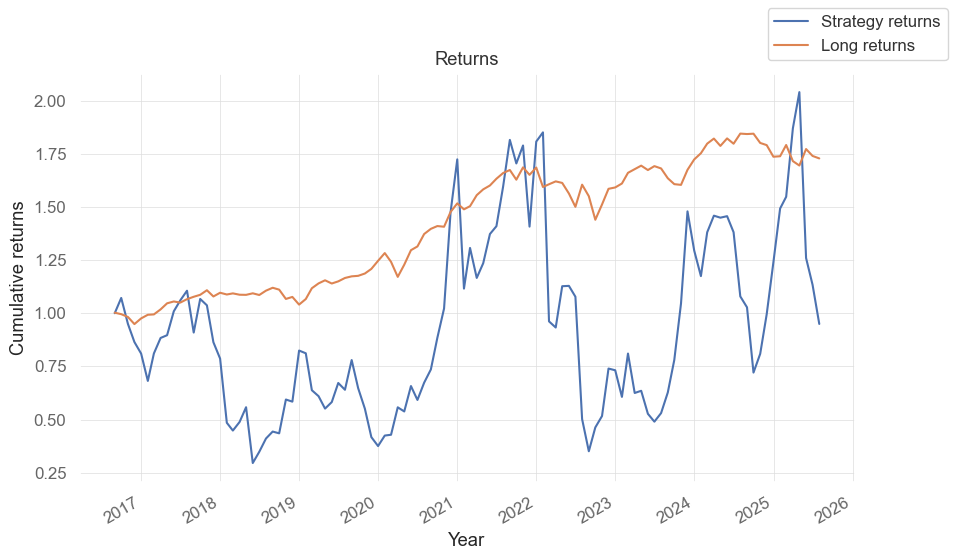

In [49]:
# Visualizing the total returns
fig, ax = plt.subplots()
ax.plot(total_returns, label='Strategy returns')
ax.plot(bench_equity, label="Long returns")
ax.set(title= "Returns",
       xlabel = "Year",
       ylabel = "Cumulative returns")
fig.autofmt_xdate()
fig.legend()

In [37]:
# Computing the standard metrics
qs.reports.metrics(strat_returns, benchmark, mode='basic', periods_per_year=12)

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2016-08-31   2016-08-31
End Period           2025-07-31   2025-07-31
Risk-Free Rate       0.0%         0.0%
Time in Market       100.0%       100.0%

Cumulative Return    552.24%      -5.04%
CAGR﹪               0.69%        -0.02%

Sharpe               0.73         0.36
Prob. Sharpe Ratio   98.26%       85.58%
Sortino              1.15         0.53
Sortino/√2           0.81         0.38
Omega                1.3          1.3

Max Drawdown         -93.59%      -81.06%
Max DD Date          2022-09-30   2022-08-31
Max DD Period Start  2021-09-30   2022-02-28
Max DD Period End    2025-07-31   2025-02-28
Longest DD Days      1401         1158

Gain/Pain Ratio      0.7          0.3
Gain/Pain (1M)       0.7          0.3

Payoff Ratio         1.19         1.09
Profit Factor        1.7          1.3
Common Sense Ratio   2.19         1.32
CPC Index            1.26         0.78
Tail Ratio   

In [38]:
# The strategy was not very effective. Let us scale weights by 12 month volatility:

# Calculate 12 month rolling volatility
rol_vol = ret_m.rolling(window=12).std()

# Create raw weights
raw_weights = signal/rol_vol

# Create the normalization divisor
norm_div = raw_weights.abs().sum(axis=1)

# Finally create the weights. Note we keep the 600% exposure.
weights = raw_weights.div(norm_div, axis=0)*6
pos_vol = weights.shift(1).fillna(0)

In [39]:
# Repeat the results calculations, using new weights.
# Calculate returns
m_returns2 = (np.exp(ret_m)-1)*pos_vol

# Creating a column with the total returns
strat_returns2 = m_returns2.sum(axis='columns')
total_returns2 = (1+strat_returns2).cumprod()

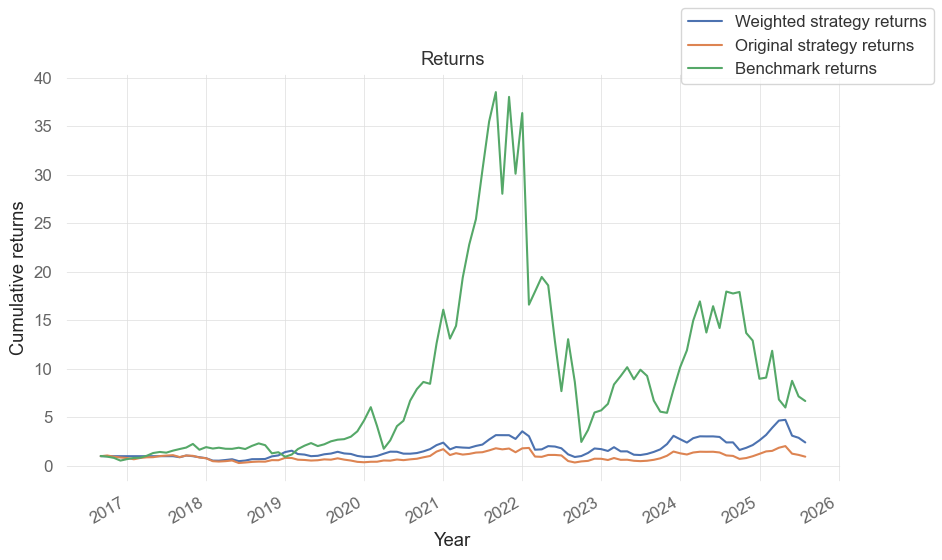

In [40]:
# Visualizing the total returns
fig, ax = plt.subplots()
ax.plot(total_returns2, label='Weighted strategy returns')
ax.plot(total_returns, label="Original strategy returns")
ax.plot(bench_equity, label="Benchmark returns")
ax.set(title= "Returns",
       xlabel = "Year",
       ylabel = "Cumulative returns")
fig.autofmt_xdate()
fig.legend()

In [41]:
# Compute the metrics:
qs.reports.metrics(strat_returns2, benchmark, mode='basic', periods_per_year=12)

                     Benchmark    Strategy
-------------------  -----------  ----------
Start Period         2016-08-31   2016-08-31
End Period           2025-07-31   2025-07-31
Risk-Free Rate       0.0%         0.0%
Time in Market       89.0%        89.0%

Cumulative Return    324.99%      141.69%
CAGR﹪               0.53%        0.33%

Sharpe               0.66         0.47
Prob. Sharpe Ratio   97.4%        91.68%
Sortino              1.05         0.72
Sortino/√2           0.74         0.51
Omega                1.43         1.43

Max Drawdown         -93.59%      -74.27%
Max DD Date          2022-09-30   2022-08-31
Max DD Period Start  2021-09-30   2022-01-31
Max DD Period End    2025-07-31   2025-01-31
Longest DD Days      1401         1097

Gain/Pain Ratio      0.67         0.43
Gain/Pain (1M)       0.67         0.43

Payoff Ratio         0.89         1.23
Profit Factor        1.67         1.43
Common Sense Ratio   2.16         1.51
CPC Index            0.93         0.95
Tail Ratio

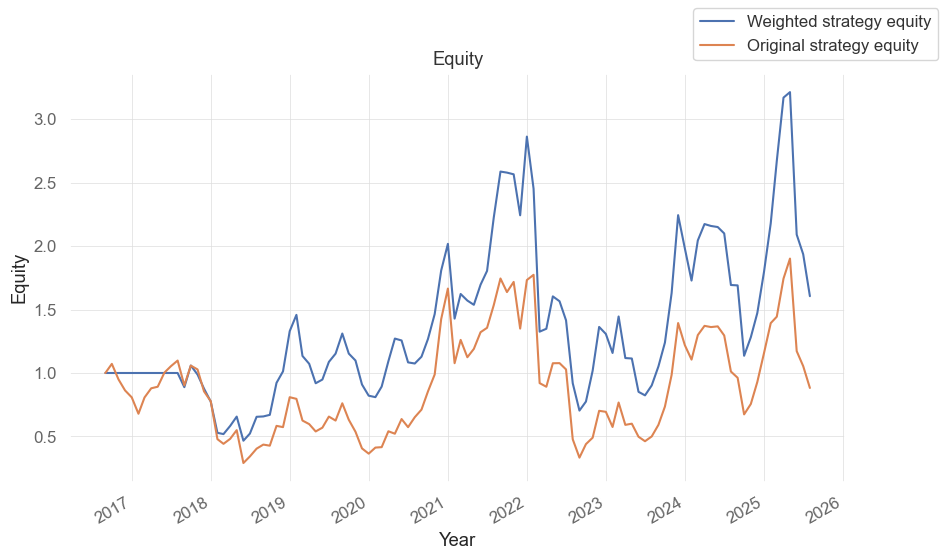

In [42]:
# Let us visualize the equity impact of both strategies. Let us assume that making a trade reduces equity by 0.5% of the turnover
w_eq = signals_shifted.div(signals_shifted.abs().sum(axis=1), axis=0)
turn_eq = w_eq.diff().abs().sum(axis=1).fillna(0)
cost_eq = 0.0005*turn_eq
equity = (1+strat_returns-cost_eq).cumprod()


turn_vol = pos_vol.diff().abs().sum(axis=1).fillna(0)
cost_vol = 0.0005*turn_vol
equity2  = (1+strat_returns2-cost_vol).cumprod()

# Visualizing the equity return of both strategies after applying transaction costs
fig, ax = plt.subplots()
ax.plot(equity2, label='Weighted strategy equity')
ax.plot(equity, label="Original strategy equity")
ax.set(title= "Equity",
       xlabel = "Year",
       ylabel = "Equity")
fig.autofmt_xdate()
fig.legend()

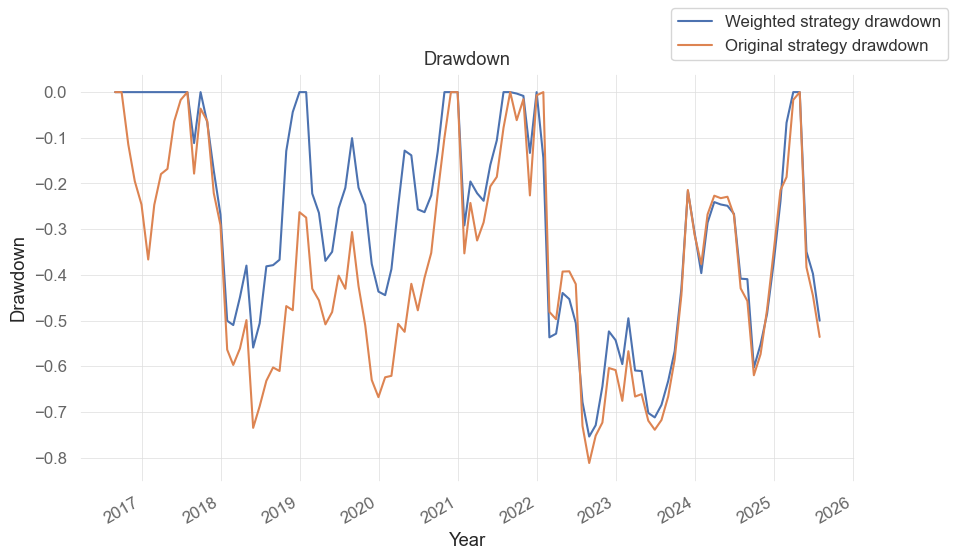

In [43]:
# Visualizing drawdown
drawdown = equity/equity.cummax()-1
drawdown2 = equity2/equity2.cummax()-1

fig, ax = plt.subplots()
ax.plot(drawdown2, label='Weighted strategy drawdown')
ax.plot(drawdown, label="Original strategy drawdown")
ax.set(title= "Drawdown",
       xlabel = "Year",
       ylabel = "Drawdown")
fig.autofmt_xdate()
fig.legend()

## Final thoughts

When comparing the two strategies, the weighted 12 month volatility strategy has higher returns, lower (in absolute terms) maximum- and general drawdown. When comparing to our benchmark, we see a greater sharpe ratio for our weighted 12 month volatility. Therefore a great opportunity for a future project, could be an optimization of this strategy, adjusting the signal and the rolling window.